# Organics-Spend Exploratory Analysis

Exploratory analysis to understand the dependence of Organic Signups on spend at the channel level. The 3 markets MX, PH, and KE were explored. In each case, data included the number of organic signups on a weekly frequency as well as the corresponding google and facebook spend. The analysis is broken down individually to each market.

---

In [265]:
import numpy as np
import pandas as pd
import plotly
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px
from scipy.optimize import optimize, curve_fit
from scipy.stats import linregress
from scipy.stats import shapiro
import statsmodels.api as sm

import plotly.io as pio

# change default plotly theme
pio.templates.default = "plotly_white"

In [266]:
# load datasets
mx_data = pd.read_csv('data/mx_organic_spend.csv', header=1)
ph_data = pd.read_csv('data/ph_organic_spend.csv', header=1)
ke_data = pd.read_csv('data/ke_organic_spend.csv', header=1)

In [267]:
def clean(data, market=None):
    
    # drop unneeded cols and rows
    if market=='MX':
        keep_cols = ['Week of ', 'Total Signups', 'Organic Signups', 
             'MX_GoogleUAC_tCPA-high_KYC-es-MX', 'MX_7/14/21_Broad_KYC - High']
        data = data.loc[:28, keep_cols]
        data = data.rename(columns={'MX_GoogleUAC_tCPA-high_KYC-es-MX': 'google_spend',
                    'MX_7/14/21_Broad_KYC - High': 'fb_spend'})
        
        data.fb_spend = data.fb_spend.str.replace('[$,]', '', regex=True).astype(float)
        
    elif market=='PH':
        keep_cols = ['Week of ', 'Total Signups', 'Organic Signups', 
             'PH_GoogleUAC_tCPA-high_KYC-en-PH', 'PH - KYC Approval - High-Score - 1D Click - NO BID']
        data = data.loc[:27, keep_cols]
        data = data.rename(columns={'PH_GoogleUAC_tCPA-high_KYC-en-PH': 'google_spend',
                    'PH - KYC Approval - High-Score - 1D Click - NO BID': 'fb_spend'})
        
        data.fb_spend = data.fb_spend.str.replace('[$,]', '', regex=True).astype(float)
        data.google_spend = data['google_spend'].str.replace('[$,]', '', regex=True).astype(float)
        
    elif market=='KE':
        keep_cols = ['Week of ', 'Total Signups', 'Organic Signups', 
             'KE_GoogleUAC_tCPA-high_KYC-en-KE', 'Tala - KE - Android']
        data = data.loc[:28, keep_cols]
        data = data.rename(columns={'KE_GoogleUAC_tCPA-high_KYC-en-KE': 'google_spend',
                    'Tala - KE - Android': 'fb_spend'})
        
        data.fb_spend = data.fb_spend.str.replace('[$,]', '', regex=True).astype(float)
        data.google_spend = data['google_spend'].str.replace('[$,]', '', regex=True).astype(float)
    
    return data

In [268]:
mx_data = clean(mx_data, market='MX')
ph_data = clean(ph_data, market='PH')
ke_data = clean(ke_data, market='KE')

In [179]:
def plot_series(data, fields, normalize=True):
    traces=[]
    for f in fields:
        if normalize:
            traces.append(go.Scatter(name=f, x=data['Week of '], y=data[f]/data[f].max()))
        else:
            traces.append(go.Scatter(name=f, x=data['Week of '], y=data[f]))
    
    fig = go.Figure(traces)
    
    if normalize:
        fig.update_layout(xaxis=dict(title='Week of'), yaxis=dict(title='Normalized Value'))
    else:
        fig.update_layout(xaxis=dict(title='Week of'), yaxis=dict(title='Value'))
    
    return fig

## MX Analysis

### Organic Spend

In [180]:
fig = plot_series(mx_data, ['Organic Signups', 'google_spend', 'fb_spend'], normalize=True)
fig.show()

The plot above shows *Organic signups*, *Google spend*, and *Facebook spend*. Each curve has been normalized by dividing it by its max value. This effectively scales all curves to between 0 and 1 so that we can compare their features on the same scale.

Comparing the *signups* curve to the *spend* curves, there appears to be some correlation between *signups* and *fb_spend*, but less so with *google_spend*. In the beginning, all 3 curves increase until around Nov, where both google and fb spend are dramatically decreased. *Signups* also begins to decrease around this point with some apparent lag behind the spend curves. From Jan on, *signups* is relatively unchanged, as is *fb_spend*, whereas *google_spend* is significantly decreased through March.

In [52]:
fig = go.Figure(data=go.Histogram(x=mx_data['Organic Signups'], xbins=dict(start=7000, end=16000, size=1000)))
fig.update_layout(title='Organic Signups Distribution')
fig.show()

The signups distribution is shown above. The data appears like it could be normally distributed but may be affected by the sparsity in the data. Additional sampling might reveal a different type of distribution but for now we'll simply test for normality.

**Null Hypothesis:** The data is sampled from a normal distribution.

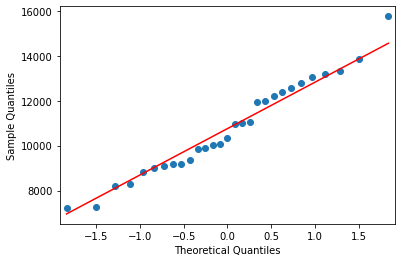

In [205]:
fig = sm.qqplot(mx_data['Organic Signups'], line='s')

### Shaprio-Wilk Test for Normality

In [206]:
alpha = 0.05

stat, p = shapiro(mx_data['Organic Signups'])

if p > alpha:
    print(f'The sample is normal (fail to reject H0). p-value: {round(p, 4)}')
else:
    print(f'The sample is NOT normal (reject H0). p-value: {round(p, 4)}')

The sample is normal (fail to reject H0). p-value: 0.5858


### Google Spend

In [181]:
fig = go.Figure(
    go.Scatter(y=mx_data['Organic Signups'], x=mx_data['google_spend'], mode='markers',
              marker=dict(size=10))
)

fig.update_layout(yaxis=dict(title='Organic Signups'),
                 xaxis=dict(title='Google Spend'))

fig.show()

The scatter plot above shows doesn't show a strong correlation between signups and spend. Let's test for normality.

In [207]:
fig = go.Figure(data=go.Histogram(x=mx_data['google_spend'], xbins=dict(start=13000, end=68000, size=10000)))
fig.update_layout(title='Google Spend Distribution')
fig.show()

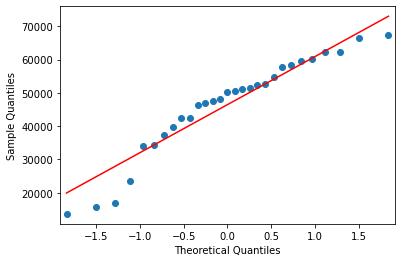

In [209]:
fig = sm.qqplot(mx_data['google_spend'], line='s')

In [210]:
alpha = 0.05

stat, p = shapiro(mx_data['google_spend'])

if p > alpha:
    print(f'The sample is normal (fail to reject H0). p-value: {round(p, 4)}')
else:
    print(f'The sample is NOT normal (reject H0). p-value: {round(p, 4)}')

The sample is NOT normal (reject H0). p-value: 0.0305


### FB Spend

In [211]:
fig = go.Figure(
    go.Scatter(y=mx_data['Organic Signups'], x=mx_data['fb_spend'], mode='markers',
              marker=dict(size=10))
)

fig.update_layout(yaxis=dict(title='Organic Signups'),
                 xaxis=dict(title='FB Spend'))

fig.show()

In [212]:
fig = go.Figure(data=go.Histogram(x=mx_data['fb_spend'], xbins=dict(start=400, end=23000, size=1000)))
fig.update_layout(title='Facebook Spend Distribution')
fig.show()

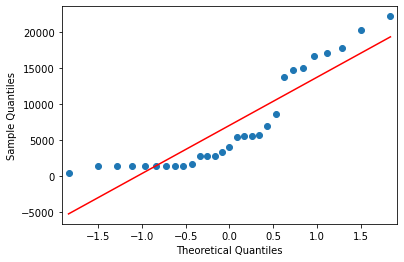

In [214]:
fig = sm.qqplot(mx_data['fb_spend'], line='s')

### Correlation Analysis

We shouldn't expect *google_spend* or *fb_spend* to be normal when these are values chosen by us and not measured, like *Organic Signups*. But this doesn't mean there isn't a strong relationship between variables. Visually, there appears to be a strong relationship between signups and fb_spend. We can still test for correlation using both Pearson's correlation as well as the Kendall Tau for non-normal distributions.

In [215]:
mx_data[['Organic Signups', 'google_spend', 'fb_spend']].cov().iloc[0]

Organic Signups    4.442689e+06
google_spend       1.896917e+06
fb_spend           1.082936e+07
Name: Organic Signups, dtype: float64

In [217]:
mx_data[['Organic Signups', 'google_spend', 'fb_spend']].corr(method='pearson').iloc[0]

Organic Signups    1.000000
google_spend       0.061167
fb_spend           0.754860
Name: Organic Signups, dtype: float64

In [218]:
mx_data[['Organic Signups', 'google_spend', 'fb_spend']].corr(method='kendall').iloc[0]

Organic Signups    1.000000
google_spend      -0.034483
fb_spend           0.551302
Name: Organic Signups, dtype: float64

Both Pearson and Kendall coeffecients show a strong correlation between signups and fb_spend, but not google_spend.

In [219]:
res = linregress(mx_data[['fb_spend', 'Organic Signups']])

In [220]:
fig = go.Figure([
    go.Scatter(name='data', y=mx_data['Organic Signups'], x=mx_data['fb_spend'], mode='markers',
              marker=dict(size=10)),
    go.Scatter(name='regression', y=(res.slope*mx_data['fb_spend'])+res.intercept, x=mx_data['fb_spend'])
])

fig.update_layout(yaxis=dict(title='Organic Signups'),
                 xaxis=dict(title='FB Spend'))

fig.show()

In [224]:
print(f'R-value: {round(res.rvalue, 2)}')

R-value: 0.75


In [301]:
print(f'Number of Organic Signups for every $1000 of FB spend: {round(1000*res.slope)}')

Number of Organic Signups for every $1000 of FB spend: 128


What we get from this equation is the relationship between FB spend and Organic Signups. We can multiply the slope by 1000 (above) to get **234 Organic Signups per $1000 spend**.

### Google vs FB Spend

In [231]:
mx_data['google-fb_spend_ratio'] = mx_data['google_spend']/mx_data['fb_spend']

In [232]:
mx_data

,Week of,Total Signups,Organic Signups,google_spend,fb_spend,google-fb_spend_ratio
0,Sep 13,23047.0,12006,16811.3600,8634.0,1.947111
1,Sep 20,29076.0,13342,34299.6100,13834.0,2.479370
2,Sep 27,30481.0,10976,48262.7883,15082.0,3.200026
3,Oct 4,33934.0,12779,46993.1924,14697.0,3.197468
4,Oct 11,32370.0,11957,52435.7489,17126.0,3.061763
5,Oct 18,35666.0,12586,60152.1109,17764.0,3.386181
6,Oct 25,33520.0,13202,62312.4957,20316.0,3.067164
7,Nov 1,34546.0,15758,59404.3068,22184.0,2.677800
8,Nov 8,30530.0,13073,51265.1000,16625.0,3.083615
9,Nov 15,30470.0,13868,46478.5473,5768.0,8.058001


In [86]:
(mx_data['google_spend']/mx_data['fb_spend']).mean()

16.850280922783437

There's a large difference in spend between google and fb channels. A new column is added to the mx_data table showing the ratio of google:fb spend (above). The ratio has increased significantly over time. Averaged over all weeks, the Google:FB spend ratio is an average of 17x. Despite this, fb continues to be the larger dependent factor of Organic Signups.

## PH

In [241]:
fig = plot_series(ph_data, ['Organic Signups', 'google_spend', 'fb_spend'], normalize=True)
fig.show()

For PH, there doesn't appear to be a correlation between FB spend and organic signups like we see in MX. There does appear to be some correlation between google spend and signups though. PH is also unique in that it shows a very large dip in both Total and Organic Signups during the Dec-Early Jan period.

In [245]:
fig = go.Figure(
    go.Scatter(y=ph_data['Organic Signups'], x=ph_data['google_spend'], mode='markers',
              marker=dict(size=10))
)

fig.update_layout(yaxis=dict(title='Organic Signups'),
                 xaxis=dict(title='Google Spend'))

fig.show()

In [246]:
fig = go.Figure(
    go.Scatter(y=ph_data['Organic Signups'], x=ph_data['fb_spend'], mode='markers',
              marker=dict(size=10))
)

fig.update_layout(yaxis=dict(title='Organic Signups'),
                 xaxis=dict(title='FB Spend'))

fig.show()

In [247]:
fig = go.Figure(data=go.Histogram(x=ph_data['Organic Signups'], xbins=dict(start=8000, end=45000, size=2000)))
fig.update_layout(title='Organic Signups Distribution')
fig.show()

Above is the *Organic Signups* distribution. The distribution appears to be somewhat normal, but may have some outliers. Let's look at the QQ plot.

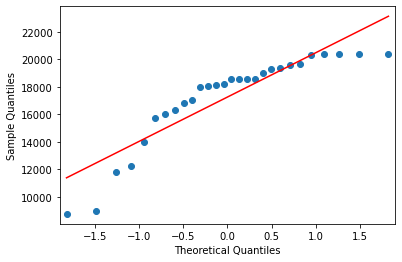

In [249]:
fig = sm.qqplot(ph_data['Organic Signups'], line='s')

There a large amount of skewness indicated by the tails. However, we can see there is a linear portion of the QQ plot which indicates a mostly normal distribution. Let's explore the outliers at the bottom end.

In [269]:
ph_data[ph_data['Organic Signups'] < 13000]

,Week of,Total Signups,Organic Signups,google_spend,fb_spend
13,Dec 13,22155.0,12252,26533.0,3855.0
14,Dec 20,16483.0,8991,25811.0,5736.0
15,Dec 27,17244.0,8770,36296.0,5728.0
16,Jan 3,21301.0,11828,30449.0,4171.0


The table above shows all points with less than 13K organic signups. They correspond with the last weeks of December and the first week of January. Below I've plotted the noramlized *Total Signups* and *Organic Signups* and we can see they track. After checking with Zu and Melissa, this large dip is believed to have been caused by more competition during the holiday period than anticipated which drove CPMs higher. Because these points are not representative of typical data, they will be omitted as outliers.

In [271]:
fig = plot_series(ph_data, ['Organic Signups', 'Total Signups'], normalize=True)
fig.show()

In [272]:
ph_data_clean = ph_data[ph_data['Organic Signups']>13000]

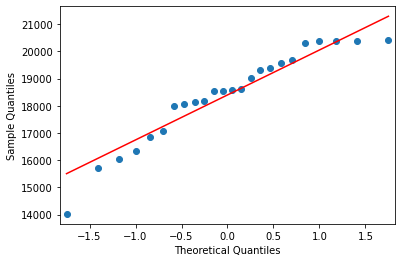

In [273]:
fig = sm.qqplot(ph_data_clean['Organic Signups'], line='s')

After removing the outliers, I've re-ran the QQ plot above and now we can see a much better fit. Below we run the test for normality and see that the data is normal.

In [283]:
alpha = 0.05

stat, p = shapiro(ph_data_clean['Organic Signups'])

if p > alpha:
    print(f'The sample is normal (fail to reject H0). p-value: {round(p, 4)}')
else:
    print(f'The sample is NOT normal (reject H0). p-value: {round(p, 4)}')

The sample is normal (fail to reject H0). p-value: 0.071


In [284]:
fig = go.Figure(
    go.Scatter(y=ph_data_clean['Organic Signups'], x=ph_data_clean['google_spend'], mode='markers',
              marker=dict(size=10))
)

fig.update_layout(yaxis=dict(title='Organic Signups'),
                 xaxis=dict(title='Google Spend'))

fig.show()

In [285]:
fig = go.Figure(
    go.Scatter(y=ph_data_clean['Organic Signups'], x=ph_data_clean['fb_spend'], mode='markers',
              marker=dict(size=10))
)

fig.update_layout(yaxis=dict(title='Organic Signups'),
                 xaxis=dict(title='FB Spend'))

fig.show()

The new scatter plots with outliers removed are shown above.

In [286]:
ph_data_clean[['Organic Signups', 'google_spend', 'fb_spend']].corr(method='pearson').iloc[0]

Organic Signups    1.000000
google_spend       0.526765
fb_spend           0.105600
Name: Organic Signups, dtype: float64

In [287]:
ph_data_clean[['Organic Signups', 'google_spend', 'fb_spend']].corr(method='kendall').iloc[0]

Organic Signups    1.000000
google_spend       0.326087
fb_spend           0.079710
Name: Organic Signups, dtype: float64

The pearson and kendall coeffecients show there is a strong correlation between *Organic Signups* and *google_spend*. 

In [288]:
res = linregress(ph_data_clean[['google_spend', 'Organic Signups']])

In [289]:
fig = go.Figure([
    go.Scatter(name='data', y=ph_data_clean['Organic Signups'], x=ph_data_clean['google_spend'], mode='markers',
              marker=dict(size=10)),
    go.Scatter(name='regression', y=(res.slope*ph_data_clean['google_spend'])+res.intercept, x=ph_data_clean['google_spend'])
])

fig.update_layout(yaxis=dict(title='Organic Signups'),
                 xaxis=dict(title='FB Spend'))

fig.show()

In [302]:
print(f'Number of Organic Signups for every $1000 of Google spend: {round(1000*res.slope)}')

Number of Organic Signups for every $1000 of Google spend: 128


The cleaned data is replotted above with the linear regression curve. **For PH the, the number of Organic Signups per $1000 of spend is 128**.

## KE

In [292]:
fig = plot_series(ke_data, ['Organic Signups', 'google_spend', 'fb_spend'], normalize=True)
fig.show()

KE shows very different trends compared to the other two markets. There is a significant increase in both *google* and *fb* spend between Jan and Mar with no apparent change to *Organic Signups*. Note that MX also doesn't show the same dip in the Dec-Jan period that we saw in PH.

In [155]:
fig = go.Figure(data=go.Histogram(x=ke_data['Organic Signups'], xbins=dict(start=1000, end=16000, size=2000)))
fig.update_layout(title='Organic Signups Distribution')
fig.show()

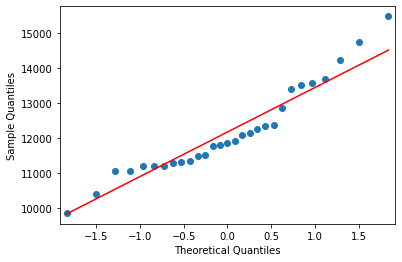

In [296]:
fig = sm.qqplot(ke_data['Organic Signups'], line='s')

In [298]:
alpha = 0.05

stat, p = shapiro(ke_data['Organic Signups'])

if p > alpha:
    print(f'The sample is normal (fail to reject H0). p-value: {round(p, 4)}')
else:
    print(f'The sample is NOT normal (reject H0). p-value: {round(p, 4)}')

The sample is normal (fail to reject H0). p-value: 0.0792


The data is normally distributed. Let's look at the trends with spend.

In [294]:
fig = go.Figure(
    go.Scatter(y=ke_data['Organic Signups'], x=ke_data['google_spend'], mode='markers',
              marker=dict(size=10))
)

fig.update_layout(yaxis=dict(title='Organic Signups'),
                 xaxis=dict(title='Google Spend'))

fig.show()

In [295]:
fig = go.Figure(
    go.Scatter(y=ke_data['Organic Signups'], x=ke_data['fb_spend'], mode='markers',
              marker=dict(size=10))
)

fig.update_layout(yaxis=dict(title='Organic Signups'),
                 xaxis=dict(title='FB Spend'))

fig.show()

As suspected, there isn't a strong trend with either channel.

In [299]:
ke_data[['Organic Signups', 'google_spend', 'fb_spend']].corr(method='pearson').iloc[0]

Organic Signups    1.000000
google_spend      -0.154317
fb_spend          -0.162579
Name: Organic Signups, dtype: float64

In [300]:
ke_data[['Organic Signups', 'google_spend', 'fb_spend']].corr(method='kendall').iloc[0]

Organic Signups    1.000000
google_spend      -0.044335
fb_spend          -0.064357
Name: Organic Signups, dtype: float64

There is no correlation between *Organic Signups* and either *google_spend* or *fb_spend*. It's not recommended to use a regression model on this data.

## Summary

1. In MX, there is a strong correlation between *Organic Signups* and *Facebook spend*. For every \$1000 in Facebook spend, Organic Signups increase by 234.
2. In PH, there is a strong correlation between *Organic Signups* and *Google spend*. For every \$1000 in Google spend, Organic Signups increase by 128.
3. In KE, no correlation was found between *Organic Signups* and either *Facebook* or *Google* spend.